In [1]:
## Gene to Gene correlation, based on clustering at high resolution and calculating the mean expression per
## cluster and correlate these to one gene of interest

## Taken R Code from Lukas and adapted
## https://github.com/lkmklsmn/HumanLungPaper/blob/master/Gene_gene_correlation_analysis_v1.R

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

# Some custom functions
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.5.1, on 2020-08-07 11:46.


In [2]:
## Ignore SpearmanRConstantInputWarning
import warnings
warnings.filterwarnings("ignore")

from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
library(pheatmap)

## Set colours
color = colorRampPalette(c("deepskyblue3", "white", "red3"))(100)
gene_col = list(gene = c("white", "red3"))

### Define R Plotting Function

In [16]:
def plot_gene_corr(means, cors, corr_gene = "NOTUM", norbmt = None, top = 50):
    cors = cors[cors.pvalue < 0.05].copy()
    genes = cors.index.values
    
    if norbmt:
        ## Exclude ribosomal / mitochondrial genes from differential gene expression table
        rbmt_genes = [name for name in genes if name.startswith('RP') | name.startswith('MT-') | name.startswith('Rp')]
        cors = cors[~cors.index.isin(rbmt_genes)]

    ## Exclude correlation gene from list to plot
    top = int(top/2)
    genes = np.concatenate((cors.index.values[1:(top + 1)], cors.index.values[-top:]))
    corr_gene_expr = means.loc[:, corr_gene].T.copy()
    corr_gene_expr.sort_values(inplace = True)

    means_plot = means.loc[:, genes].T
    means_plot = means_plot.loc[:, corr_gene_expr.index.values]
    print(means_plot.shape)
    
    %R -i corr_gene names(gene_col) <- corr_gene    
    %R -i genes -i corr_gene_expr -i means_plot -i top anno_row <- data.frame(sign = c(rep("pos", top), rep("neg", top)))
    %R rownames(anno_row) <- genes
    %R anno_col <- data.frame(gene = corr_gene_expr)
    %R colnames(anno_col) <- corr_gene
    %R rownames(anno_col) <- colnames(means_plot)

    %R -w 800 -h 600 p <- pheatmap(means_plot, scale = 'row', cluster_cols = F, show_colnames = F, \
                                                 col = color, annotation_row = anno_row, annotation_col = anno_col, \
                                                 breaks = seq(-2, 2, length = 100), annotation_colors = gene_col, \
                                                 main = paste("Correlation to", corr_gene))
    

### Read in adata object

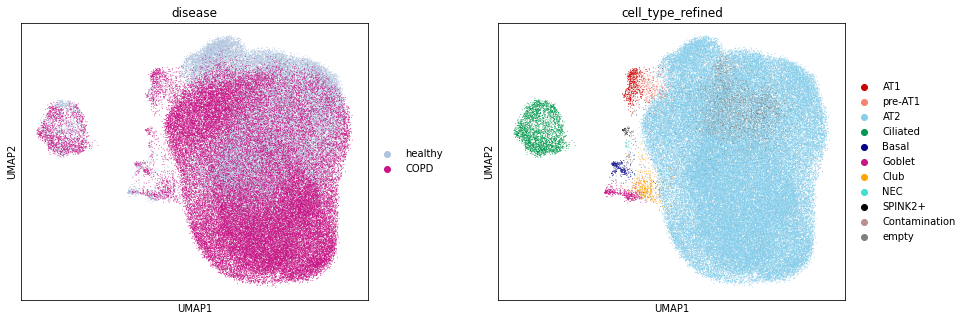

In [5]:
plt.rcParams["figure.figsize"] = (6, 5)
folder = "/mnt/platte_1/Projects/200614_Denver_MKCOPD79_80/"
sc.settings.cachedir = "/mnt/platte_2/cache/"
adata = sc.read(folder + "200722_COPD_all_patients_souped.h5ad", cache = True)

sc.pl.umap(adata, color = ["disease", "cell_type_refined"], size = 3, wspace = 0.25)

### Subset to cell type of interest and run louvain clustering at a higher resolution

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 45 clusters and added
    'overcluster', the cluster labels (adata.obs, categorical) (0:00:22)
45


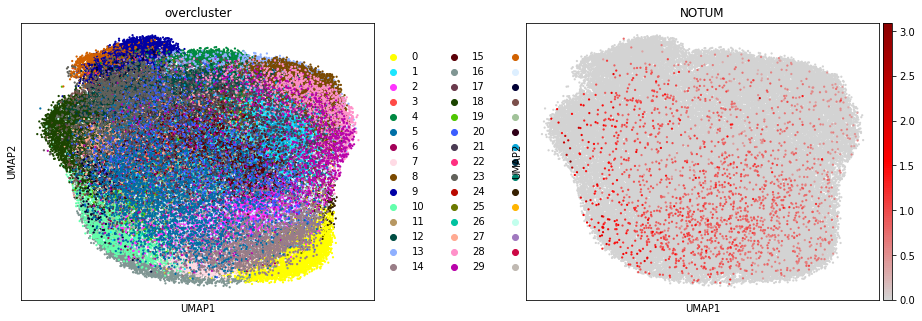

In [6]:
sub = adata[(adata.obs.cell_type_refined.isin(["AT2"]))].copy()
sc.pp.pca(sub)
sc.pp.neighbors(sub, n_pcs = 30, n_neighbors = 20)
sc.tl.louvain(sub, resolution = 5, key_added = "overcluster")
print(len(np.unique(sub.obs.overcluster)))

sc.pl.umap(sub, color = ["overcluster", "NOTUM"], cmap = gray_red, wspace = 0.3, size = 20)

In [7]:
## if desired, filter out lowly expressed genes (here we have quite a lot of AT2 cells, so I’m setting it super high)
sc.pp.filter_genes(sub, min_cells = 500)

filtered out 2777 genes that are detected in less than 500 cells


### Calculate Mean Expression in these new clusters and correlate to gene of interest

In [9]:
corr_gene = "NOTUM"

genExp = codes.generate_expr_table(sub, xlabel = "overcluster", use_raw = True)
genExp.drop("identifier", inplace = True, axis = 1)

## Mean expression table
meanExp = genExp.groupby(["overcluster"]).mean().reset_index()
meanExp.set_index("overcluster", inplace = True)
print(meanExp.shape)

cors = codes.correlate_means_to_gene(meanExp, corr_gene = corr_gene)
cors.head(10)

(45, 17351)


,spearman_corr,pvalue
NOTUM,1,0
LHX4,0.824909,3.22617e-12
CORIN,0.811042,1.43236e-11
EPHX1,0.809091,1.74943e-11
ALDH1A2,0.805672,2.46987e-11
KDM6B,0.786034,1.58302e-10
VSIG2,0.777734,3.27839e-10
RGCC,0.775099,4.1042e-10
CYB5D1,0.774308,4.38778e-10
TPPP3,0.766403,8.43626e-10


In [ ]:
## Can save this table with correlation values
out_folder = "/path/to/folder/"
cors.to_csv(out_folder + "%s_correlation.txt" %corr_gene, sep = "\t")

### Plot using PHeatmap

(50, 45)


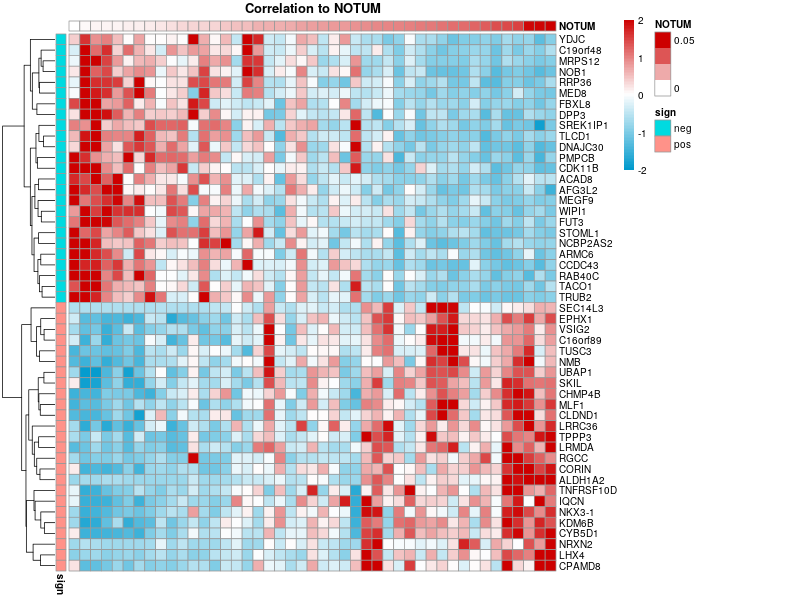

In [17]:
plot_gene_corr(meanExp, cors, corr_gene = corr_gene, norbmt = None, top = 50)

### Save the last heatmap in plot_folder

In [ ]:
plot_folder = "/home/agando/Documents/Meshal/PhD_Scripts/Denver_IPF_COPD/regenerate_only_COPD_pairs"\
             "/preprocess_add_2final_COPDs/Plots/gene_correlation/"

In [65]:
%%R -i plot_folder
pdf(paste0(plot_folder, "filename.pdf"), width = 10, height = 7,5)
grid::grid.newpage()
grid::grid.draw(p$gtable)
dev.off()

[1] 2
